# CSE 256 Assignment1

In [43]:
import time
import re
import pandas as pd
import numpy as np
import tarfile
from wordcloud import WordCloud, STOPWORDS
import nltk.data
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm.notebook import tqdm
from matplotlib import cm
%matplotlib inline


## 1.1 Baseline of CountVectorizer

In [1]:
!python sentiment.py

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels

Training classifier

Evaluating
  Accuracy on train  is: 0.9821038847664775
  Accuracy on dev  is: 0.777292576419214


### 1.1.1 Load data

In [3]:
trainfname = './data/sentiment/train.tsv'
devfname = './data/sentiment/dev.tsv'
unlabeledfname = './data/sentiment/unlabeled.tsv'
outfname = "data/sentiment-pred.csv"

In [5]:
train = pd.read_csv(trainfname, sep='\t', header=None, names=['label', 'review'])  # read train
dev = pd.read_csv(devfname, sep='\t', header=None, names=['label', 'review'])  # read dev
dev = dev.dropna()
train.head(5)

,label,review
0,POSITIVE,Went last night for the first time with my boy...
1,POSITIVE,I have gone to Silvercreek several times - fo...
2,NEGATIVE,This place is an absolute joke! I don't even k...
3,NEGATIVE,"The food is NOT good , but the music is..."
4,POSITIVE,This is definitely one of my favourite spots f...


In [6]:
tarfname = './data/sentiment.tar.gz'
unlabeledname = 'sentiment/unlabeled.tsv'
tar = tarfile.open(tarfname, "r:gz")

### 1.1.2 Comparing CountVectorizer and TfidVectorizer

In [9]:
def display_scores(vectorizer, tfidf_result):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(sorted_scores, columns=["features", "weight"])

In [10]:
vec1 = CountVectorizer().fit(train["review"])
vec2 = TfidfVectorizer().fit(train["review"])

In [11]:
score1 = display_scores(vec1, vec1.transform(train["review"]))
score2 = display_scores(vec2, vec2.transform(train["review"]))

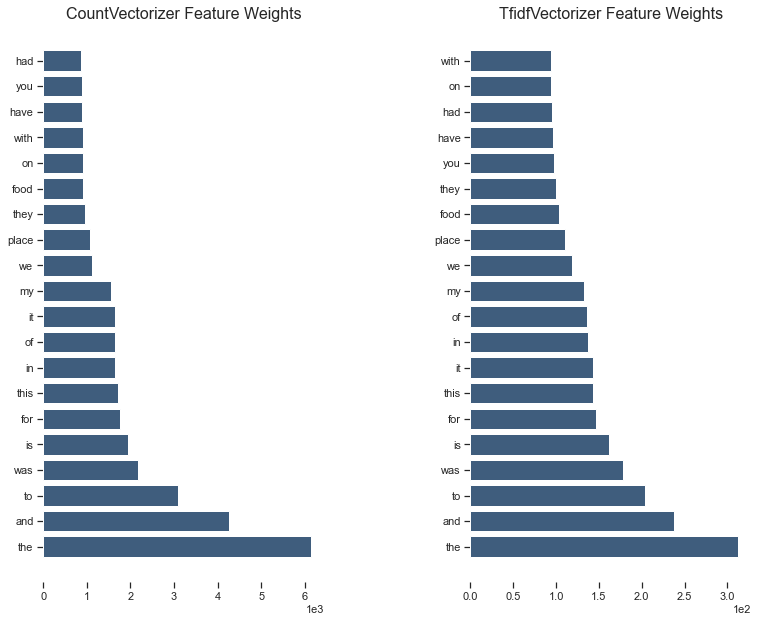

In [315]:
scores = [score1, score2]
titles = ["CountVectorizer Feature Weights", "TfidfVectorizer Feature Weights"]
fig = plt.figure(figsize=(12, 9), facecolor="w")
num = len(scores)
for i, score in enumerate(scores):
    ax = fig.add_subplot(1, num, i+1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_title(titles[i], fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.barh(score["features"][:20], score["weight"][:20], align='center', color='#3F5D7D')
    plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
plt.savefig('./pics/pic2.png')
plt.show()


#### Conclusion:
Since our goal is predict the sentiment(POSITIVE or NEGATIVE) behind reviews, I want to extract the feature which can assemble the emotion or highly related to this emotion. In another hand, I don’t want to some words whose occurrence is huge(like article) but with no relationship with the emotion to interfere my vectorizer. So I choose TfidVectorizer to replace the original CountVectorizer. 

The figure above shows the difference between these two methods, we can see that in CountVectorizer, words that occurs a commonly like "the", "and" weigh greatly. When we use TfidfVectorizer, we soften the weigh of these words. Although "the" still takes the first place, the weight of it is more similar to other words’ weight in TfidfVectorizer.

## 2.1 Guided Feature Engineering

In [18]:
tfidf_vectorizer = TfidfVectorizer().fit(train["review"])

In [23]:
X_train = tfidf_vectorizer.transform(train['review'])
y_train = train['label']
X_dev = tfidf_vectorizer.transform(dev['review'])
y_dev = dev['label']

In [20]:
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)
cls.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [288]:
cls.score(X_train, y_train), cls.score(X_dev, y_dev)

(0.9020078568310781, 0.7690476190476191)


The accuracy of train set and dev set is (0.9020078568310781, 0.7690476190476191).  
I used default settings on both models, next I will tune hyperparamters to get better result on dev set.

### 2.1.1 Tuning hyperparamters

I tested hyperparameters: $ngram, C$

$ngram = (m, n)$ means we take at least $m$ words and at most $n$ words in a whole as a feature, in this case, neither take $m$ and $n$ too small nor too big. That means We don’t want to make the number of features too large and still want to keep the relationship between words. I tested it on the range of 

$C$ in LogisticRegression model, as said in documentation of sklean, the smaller the value of $C$, the higher the stronger regularization is. So it affects the model performance to some extent.

In [28]:
res = []
ngram = [(1, 1), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
for c in tqdm(np.arange(1, 2.6, 0.1)):
    for n in ngram:
        tfidf_vectorizer = TfidfVectorizer(ngram_range=n).fit(train["review"])
        X_train = tfidf_vectorizer.transform(train['review'])
        y_train = train['label']
        X_dev = tfidf_vectorizer.transform(dev['review'])
        y_dev = dev['label']
        cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000 ,C=c)
        cls.fit(X_train, y_train)
        res.append((cls.score(X_train, y_train), cls.score(X_dev, y_dev)))
print(res)

  0%|          | 0/16 [00:00<?, ?it/s]

[(0.9020078568310781, 0.7690476190476191), (0.9570056743780009, 0.7761904761904762), (0.9801396769969446, 0.7761904761904762), (0.990615451767787, 0.7666666666666667), (0.9975993016150153, 0.719047619047619), (0.9995635093845482, 0.7309523809523809), (0.9997817546922741, 0.6642857142857143), (0.9052815364469664, 0.7666666666666667), (0.9615888258402444, 0.7761904761904762), (0.9821038847664775, 0.7785714285714286), (0.9921431689218682, 0.7690476190476191), (0.9978175469227412, 0.7214285714285714), (0.9997817546922741, 0.7285714285714285), (0.9997817546922741, 0.6642857142857143), (0.9076822348319511, 0.7666666666666667), (0.9644260148406809, 0.7761904761904762), (0.9851593190746399, 0.7785714285714286), (0.9938891313836753, 0.7738095238095238), (0.9984722828459188, 0.7214285714285714), (1.0, 0.7285714285714285), (0.9997817546922741, 0.6642857142857143), (0.9105194238323876, 0.7619047619047619), (0.9679179397642951, 0.780952380952381), (0.9871235268441728, 0.7785714285714286), (0.994980

In [38]:
dev_res = [r[1] for r in res]
dev_res = np.array(dev_res).reshape((-1, 7))
print(dev_res.shape)
print(dev_res)

(16, 7)
[[0.76904762 0.77619048 0.77619048 0.76666667 0.71904762 0.73095238
  0.66428571]
 [0.76666667 0.77619048 0.77857143 0.76904762 0.72142857 0.72857143
  0.66428571]
 [0.76666667 0.77619048 0.77857143 0.77380952 0.72142857 0.72857143
  0.66428571]
 [0.76190476 0.78095238 0.77857143 0.77619048 0.72380952 0.72619048
  0.66428571]
 [0.76190476 0.78095238 0.78095238 0.77619048 0.72857143 0.72619048
  0.66904762]
 [0.76428571 0.78333333 0.78333333 0.77619048 0.73095238 0.72380952
  0.66904762]
 [0.76428571 0.78333333 0.78333333 0.77619048 0.73095238 0.72619048
  0.66904762]
 [0.76190476 0.78571429 0.78333333 0.77619048 0.73095238 0.72619048
  0.66904762]
 [0.76666667 0.78571429 0.78333333 0.77619048 0.73095238 0.72619048
  0.66904762]
 [0.76666667 0.78571429 0.78571429 0.77380952 0.73333333 0.72619048
  0.66904762]
 [0.77142857 0.78571429 0.78571429 0.77380952 0.73333333 0.72857143
  0.66666667]
 [0.77380952 0.78571429 0.78571429 0.77380952 0.73333333 0.72857143
  0.66666667]
 [0.7761

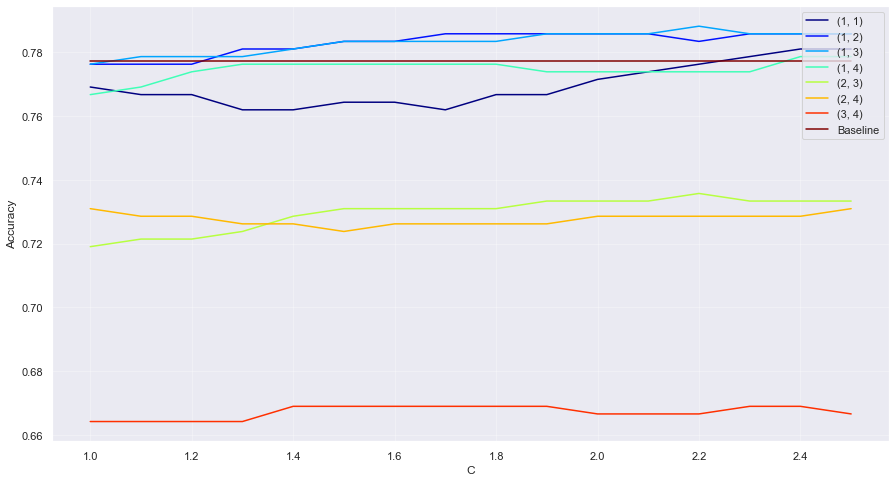

In [316]:
x = np.arange(1, 2.6, 0.1)
plt.figure(figsize=(15,8))
for i in range(len(ngram)):
    plt.plot(x, dev_res[:,i], color = cm.jet(1.*i/7), label = str(ngram[i]))
    
plt.plot(x, [0.777292576419214]*16, color = cm.jet(1.*10/7), label = 'Baseline')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.savefig('./pics/pic3.png')
plt.show()


In [287]:
df = pd.DataFrame(dev_res, columns = [str(n) for n in ngram], index = ["{:.2f}".format(ind) for ind in x])
print(df)

        (1, 1)    (1, 2)    (1, 3)    (1, 4)    (2, 3)    (2, 4)    (3, 4)
1.00  0.769048  0.776190  0.776190  0.766667  0.719048  0.730952  0.664286
1.10  0.766667  0.776190  0.778571  0.769048  0.721429  0.728571  0.664286
1.20  0.766667  0.776190  0.778571  0.773810  0.721429  0.728571  0.664286
1.30  0.761905  0.780952  0.778571  0.776190  0.723810  0.726190  0.664286
1.40  0.761905  0.780952  0.780952  0.776190  0.728571  0.726190  0.669048
1.50  0.764286  0.783333  0.783333  0.776190  0.730952  0.723810  0.669048
1.60  0.764286  0.783333  0.783333  0.776190  0.730952  0.726190  0.669048
1.70  0.761905  0.785714  0.783333  0.776190  0.730952  0.726190  0.669048
1.80  0.766667  0.785714  0.783333  0.776190  0.730952  0.726190  0.669048
1.90  0.766667  0.785714  0.785714  0.773810  0.733333  0.726190  0.669048
2.00  0.771429  0.785714  0.785714  0.773810  0.733333  0.728571  0.666667
2.10  0.773810  0.785714  0.785714  0.773810  0.733333  0.728571  0.666667
2.20  0.776190  0.783333 

### Conclusion:
As we can see in the figure and table above:
1. As the increasing of $m, n$ in $ngram$ ($ngram = (m, n)$), the accuracy is decreasing when $m > 1$.
2. The value of $C$ doesn't influence the accuracy greatly.
3. The best hyperparameter is $ngram = (1, 3)$, $C = 2.2$.
4. The best accuracy on dev data set is **0.788095**.

## 2.2 Independent Feature Engineering

### 2.2.1 Preprocess texts
There are many features contain digits and punctuations. So I use regex expression to filter some features(words) with number, punctuations.  
The baseline has 9882 features and after I remove some, the number of features is 9665. The original model has some features like "000", "01am" which don’t occur in model after preprocesses.

In [60]:
def preprocessor(text):
    text = re.sub(r"u'", '', text)
    text = re.sub(r'^\s*\+{3}.*\+{3}\s*$', '', text,
                  flags=re.DOTALL | re.MULTILINE | re.UNICODE)
    text = re.sub(r'^\s*```.*?```\s*$', '', text,
                  flags=re.DOTALL | re.MULTILINE)
    text = re.sub(r'`[^`]*`', '', text)
    text = re.sub(r'<[^>]*>', '', text, flags=re.UNICODE |
                  re.DOTALL | re.MULTILINE)
    text = text.replace('<!--more--><!--ad-->', '')
    text = re.sub(r'\d*', '', text)
    text = text.lower()
    text = re.sub(r'[\W]+', ' ', text.lower(), flags=re.UNICODE)

    return text

In [291]:
TfidfVectorizer().fit(train["review"]).transform(train['review']).shape

(4582, 9882)

In [294]:
TfidfVectorizer().fit([preprocessor(t) for t in train["review"]]).transform(train['review']).shape

(4582, 9665)

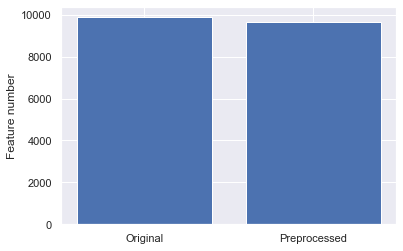

In [317]:
x_lable = ['Original', 'Preprocessed']
features = [9882, 9665]
plt.ylabel('Feature number')
plt.bar(x_lable, features)
plt.savefig('./pics/pic5.png')
plt.show()

In [73]:
tfidf_vectorizer = TfidfVectorizer(decode_error='strict', lowercase=True, ngram_range=(1, 3), \
          strip_accents='unicode', sublinear_tf=True,use_idf=True).fit([preprocessor(t) for t in train["review"]])

In [75]:
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000 ,C=2.2)
cls.fit(X_train, y_train)

LogisticRegression(C=2.2, max_iter=10000, random_state=0)

In [91]:
cls.score(X_train, y_train), cls.score(X_dev, y_dev)

(0.9875600174596246, 0.7952380952380952)

#### Conclusion:
I used the same hyperparamters above, the dev accuracy becomes higher: **0.7952380952380952**.

----
I used Gridsearch method to find the model which performs best on dev part.

In [61]:
total = pd.concat([train, dev])  # concat train set and dev set
total.shape

(5002, 2)

In [62]:
# Since we have split train set and dev set, we have to make it together
test_folder = np.zeros(total.shape[0])
test_folder[:train.shape[0]] = -1
ps = PredefinedSplit(test_folder)

In [86]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='unicode',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True)),
    ('clf', LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)),
])
parameters = {
    'tfidf__stop_words': (None, 'english'),
    'tfidf__preprocessor': (None, preprocessor),
    'tfidf__ngram_range': ngram,
    'clf__C': np.arange(1, 2.6, 0.1)
}


In [87]:
grid_search_tune = GridSearchCV(pipeline, parameters, verbose=3, n_jobs=-1, cv=ps)
grid_search_tune.fit(total['review'], total['label'])

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)
print(grid_search_tune.best_estimator_)


Fitting 1 folds for each of 448 candidates, totalling 448 fits
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.769 total time=   0.3s
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 3), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.781 total time=   2.0s


/Users/zixuanwang/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None, tfidf__stop_words=english;, score=0.764 total time=   0.3s
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 3), tfidf__preprocessor=None, tfidf__stop_words=english;, score=0.752 total time=   1.1s
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(2, 3), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.729 total time=   2.0s
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 1), tfidf__preprocessor=<function preprocessor at 0x7f9310a62ee0>, tfidf__stop_words=None;, score=0.774 total time=   0.7s
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 4), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.781 total time=   3.1s
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7fd730beaee0>, tfidf__stop_words=english;, score=0.752 total time=   1.0s
[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(1, 4), tfidf__preprocessor=<function preprocessor at 0x7fd6e02dddc0>

[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(1, 3), tfidf__preprocessor=<function preprocessor at 0x7fd77859aee0>, tfidf__stop_words=None;, score=0.774 total time=   2.7s
[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(3, 4), tfidf__preprocessor=None, tfidf__stop_words=english;, score=0.533 total time=   0.9s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.774 total time=   0.3s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 1), tfidf__preprocessor=<function preprocessor at 0x7fd7aa198040>, tfidf__stop_words=english;, score=0.767 total time=   0.6s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7fd7aa198160>, tfidf__stop_words=None;, score=0.776 total time=   1.0s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 4), tfidf__preprocessor=None, tfidf__stop_words=english;, score=0.757 total time=   1.2s
[CV 1/1] END clf

Best parameters set:
[('tfidf', TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode', sublinear_tf=True)), ('clf', LogisticRegression(C=2.4000000000000012, max_iter=10000, random_state=0))]
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=2.4000000000000012, max_iter=10000,
                                    random_state=0))])
[CV 1/1] END clf__C=1.8000000000000007, tfidf__ngram_range=(1, 2), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.788 total time=   0.9s
[CV 1/1] END clf__C=1.8000000000000007, tfidf__ngram_range=(2, 3), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.736 total time=   1.9s
[CV 1/1] END clf__C=1.8000000000000007, tfidf__ngram_range=(2, 4), tfidf__preprocessor=<function preprocessor at 0x7ff4a8c8fdc0>, tfidf__stop_words=english;, score=0.664 total time=   1.9s
[CV 1

[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 3), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.781 total time=   1.7s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(2, 4), tfidf__preprocessor=<function preprocessor at 0x7f9ce8786dc0>, tfidf__stop_words=english;, score=0.660 total time=   1.7s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(3, 4), tfidf__preprocessor=<function preprocessor at 0x7f9d18dda3a0>, tfidf__stop_words=None;, score=0.664 total time=   2.2s
[CV 1/1] END clf__C=1.3000000000000003, tfidf__ngram_range=(1, 4), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.781 total time=   3.3s
[CV 1/1] END clf__C=1.3000000000000003, tfidf__ngram_range=(3, 4), tfidf__preprocessor=None, tfidf__stop_words=english;, score=0.533 total time=   0.8s
[CV 1/1] END clf__C=1.4000000000000004, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.771 total time=   0.3s
[CV 1/1] END clf__C=1.4000

[CV 1/1] END clf__C=1.9000000000000008, tfidf__ngram_range=(2, 3), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.738 total time=   2.2s
[CV 1/1] END clf__C=1.9000000000000008, tfidf__ngram_range=(3, 4), tfidf__preprocessor=<function preprocessor at 0x7f94e1145dc0>, tfidf__stop_words=english;, score=0.529 total time=   1.6s
[CV 1/1] END clf__C=2.000000000000001, tfidf__ngram_range=(1, 2), tfidf__preprocessor=<function preprocessor at 0x7f94e11423a0>, tfidf__stop_words=english;, score=0.762 total time=   1.6s
[CV 1/1] END clf__C=2.000000000000001, tfidf__ngram_range=(1, 4), tfidf__preprocessor=<function preprocessor at 0x7f94e1142280>, tfidf__stop_words=english;, score=0.755 total time=   3.6s
[CV 1/1] END clf__C=2.000000000000001, tfidf__ngram_range=(2, 4), tfidf__preprocessor=<function preprocessor at 0x7f94e1142550>, tfidf__stop_words=None;, score=0.733 total time=   5.8s
[CV 1/1] END clf__C=2.100000000000001, tfidf__ngram_range=(1, 4), tfidf__preprocessor=None, tfidf__st

[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(2, 4), tfidf__preprocessor=<function preprocessor at 0x7f8f405aaee0>, tfidf__stop_words=None;, score=0.736 total time=   2.7s
[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(1, 4), tfidf__preprocessor=None, tfidf__stop_words=english;, score=0.757 total time=   1.6s
[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(2, 3), tfidf__preprocessor=<function preprocessor at 0x7f8f60beb3a0>, tfidf__stop_words=None;, score=0.738 total time=   2.5s
[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(3, 4), tfidf__preprocessor=<function preprocessor at 0x7f8f60beb670>, tfidf__stop_words=None;, score=0.664 total time=   2.0s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 3), tfidf__preprocessor=<function preprocessor at 0x7f8f60beb160>, tfidf__stop_words=english;, score=0.750 total time=   1.2s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(2, 3), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.731 total time=   1.5s
[CV 1/1] END

[CV 1/1] END clf__C=1.0, tfidf__ngram_range=(3, 4), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.664 total time=   1.7s
[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(1, 3), tfidf__preprocessor=<function preprocessor at 0x7fd0c8332dc0>, tfidf__stop_words=english;, score=0.750 total time=   1.4s
[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(2, 3), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.729 total time=   1.9s
[CV 1/1] END clf__C=1.1, tfidf__ngram_range=(2, 4), tfidf__preprocessor=<function preprocessor at 0x7fd0e9996310>, tfidf__stop_words=english;, score=0.660 total time=   2.0s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 1), tfidf__preprocessor=None, tfidf__stop_words=english;, score=0.767 total time=   0.3s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 2), tfidf__preprocessor=None, tfidf__stop_words=None;, score=0.783 total time=   0.9s
[CV 1/1] END clf__C=1.2000000000000002, tfidf__ngram_range=(1, 3), tfidf__preproces

In [88]:
grid_search_tune.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=2.4000000000000012, max_iter=10000,
                                    random_state=0))])

In [72]:
tfidf_vectorizer = TfidfVectorizer(decode_error='strict', lowercase=True, ngram_range=(1, 2), \
          strip_accents='unicode', sublinear_tf=True,use_idf=True).fit([preprocessor(t) for t in train["review"]])
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000 ,C=2.4)
cls.fit(X_train, y_train)
cls.score(X_train, y_train), cls.score(X_dev, y_dev)

(0.9559144478393714, 0.8047619047619048)

#### Conclusion:
I found a better result with GridSearch: **0.8047619047619048**.

### 2.2.2 Use Word2Vec to extract features

In [94]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

In [95]:
def review_to_wordlist(review):
    text = preprocessor(review)
    words = text.split()
    return(words)

In [96]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def review_to_sentences(review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence))
    return sentences

In [97]:
sentences = []

for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)


In [267]:
num_features = 50
min_word_count = 2
num_workers = 4       
context = 5         
downsampling = 5e-3 
sg = 0
alpha=0.05
# negwords = 6

model = Word2Vec(sentences, sg=sg, workers=num_workers, vector_size=num_features, min_count = min_word_count, \
                 window = context, cbow_mean=1, hs=0, sample = downsampling, \
                 alpha = alpha, min_alpha = 1e-5) # , negative = negwords)

In [269]:
model.wv.most_similar('good'), model.wv.most_similar('awful')

([('great', 0.8173513412475586),
  ('fast', 0.7630858421325684),
  ('bad', 0.7569719552993774),
  ('nice', 0.7550837397575378),
  ('ok', 0.7261162400245667),
  ('decent', 0.7099089026451111),
  ('busy', 0.7031325101852417),
  ('terrible', 0.7017742395401001),
  ('high', 0.7014501690864563),
  ('wonderful', 0.7003716230392456)],
 [('toward', 0.8935975432395935),
  ('orange', 0.8910602927207947),
  ('inattentive', 0.8908618688583374),
  ('acceptable', 0.8894691467285156),
  ('lacking', 0.8890858888626099),
  ('poor', 0.8853660821914673),
  ('extremely', 0.8836950063705444),
  ('terrible', 0.8792463541030884),
  ('bland', 0.8730683326721191),
  ('slow', 0.8712881207466125)])

In [270]:
voc = model.wv.index_to_key

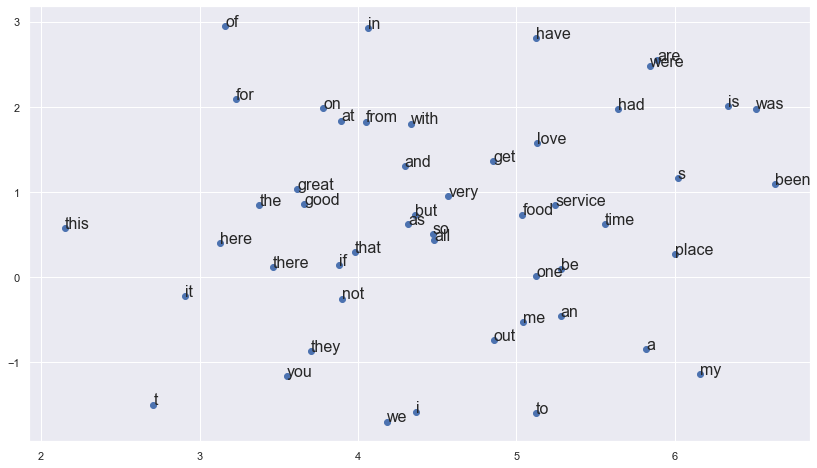

In [296]:
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(model.wv[voc[:50]])

plt.figure(figsize=(14, 8)) 

plt.scatter(X_tsne[:,0],X_tsne[:,1])
for i in range(len(X_tsne)):
    x=X_tsne[i][0]
    y=X_tsne[i][1]
    plt.text(x , y ,voc[:50][i], size = 16)
plt.show()

In [307]:
np.seterr(divide='ignore', invalid='ignore')
def makeFeatureVec(words, model, num_features, glove):
    featureVec = np.zeros((num_features,))
    nwords = 0
    if glove == True:
        index2word_set = set(model.index_to_key)
    else:
        index2word_set = set(model.wv.index_to_key)
    
    # if this word in wordset
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            if glove == True:
                featureVec = np.add(featureVec, model[word])
            else:
                featureVec = np.add(featureVec, model.wv[word])
    if nwords == 0:
        return featureVec
    # get average vector
    featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features, glove):
    counter = 0
    
    reviewFeatureVecs = np.zeros((len(reviews),num_features))
    
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features, glove)
        counter += 1
    return reviewFeatureVecs

In [273]:
train_reviews = []
for review in train["review"]:
    train_reviews.append(review_to_wordlist(review))
trainDataVecs = getAvgFeatureVecs(train_reviews, model, num_features, False)

dev_reviews = []
for review in dev["review"]:
    dev_reviews.append(review_to_wordlist(review))
devDataVecs = getAvgFeatureVecs(dev_reviews, model, num_features, False)


In [274]:
newcls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)
newcls.fit(trainDataVecs, y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [309]:
def find_bestc(trainDataVecs, devGloveVecs):
    newpara = {'C':np.arange(0.5, 2.5, 0.1)}
    clff = GridSearchCV(newcls, newpara, cv=ps).fit(np.concatenate([trainDataVecs, devDataVecs]), \
                                                    pd.concat([y_train, y_dev]))
    print(clff.best_estimator_)

In [276]:
find_bestc(trainDataVecs, devGloveVecs)

LogisticRegression(C=0.8999999999999999, max_iter=10000, random_state=0)


In [277]:
newcls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=0.9)
newcls.fit(trainDataVecs, y_train)
newcls.score(devDataVecs, y_dev)

0.6904761904761905

### 2.2.3 Using pretrained model

In [192]:
model_glove = gensim.models.KeyedVectors.load_word2vec_format("./glove.txt",binary=False) #GloVe Model

In [300]:
model_glove.most_similar("good")

[('better', 0.9284391403198242),
 ('really', 0.9220624566078186),
 ('always', 0.9165270924568176),
 ('sure', 0.903351366519928),
 ('something', 0.901420533657074),
 ('think', 0.8982065320014954),
 ('way', 0.8953989744186401),
 ('thing', 0.894504964351654),
 ('little', 0.8941226005554199),
 ('very', 0.8919912576675415)]

In [308]:
num_features2 = 50
trainGloveVecs = getAvgFeatureVecs(train_reviews, model_glove, num_features2, True)
devGloveVecs = getAvgFeatureVecs(dev_reviews, model_glove, num_features2, True)

In [310]:
find_bestc(trainGloveVecs, devGloveVecs)

LogisticRegression(C=1.9999999999999996, max_iter=10000, random_state=0)


In [311]:
cls_glove = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000,C=2)
cls_glove.fit(trainGloveVecs, y_train)
cls_glove.score(devGloveVecs, y_dev)

0.7238095238095238